In [586]:
img_global = "test\inclined_3.jpg"

# Imports

In [587]:
import cv2
import numpy as np
import scipy.ndimage as rt
from matplotlib import pyplot as plt
import shutil
import os
import string
import random

# Pre-requisites

In [588]:

if os.path.exists('Line_Segment'):
    shutil.rmtree('Line_Segment')
if os.path.exists('Char_Segment'):
    shutil.rmtree('Char_Segment')

In [589]:
img = cv2.imread(img_global)

# Line segmentation
* Noise Removal  and Skeletonization
* Otsu thresholding
* skew angle correction

In [590]:
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = rt.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)

    return best_angle, corrected

In [591]:
angle, corrected = correct_skew(img)
print(angle)

-4


In [592]:
cv2.imshow('skew_corrected', img)
cv2.waitKey(0)

-1

In [593]:
cv2.imshow('skew_corrected', corrected)
cv2.waitKey(0)

-1

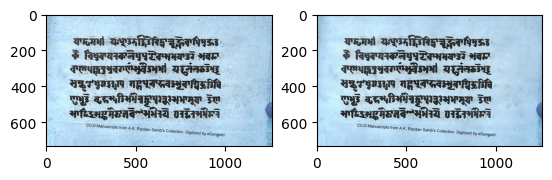

In [594]:
# denoising of image saving it into dst image 
dst = cv2.fastNlMeansDenoisingColored(corrected, None, 10, 10, 7, 15) 
# Plotting of source and destination image 
plt.subplot(121), plt.imshow(corrected) 
plt.subplot(122), plt.imshow(dst) 
plt.show()

In [595]:
kernel = np.ones((1,1),np.uint8)
erosion = cv2.erode(dst,kernel,iterations = 1)
cv2.imshow('Erosion',erosion)
cv2.waitKey(0)

-1

In [596]:
img_gray = cv2.cvtColor(erosion, cv2.COLOR_BGR2GRAY)
ret, imgf = cv2.threshold(img_gray, 125, 255,cv2.THRESH_BINARY_INV,cv2.THRESH_OTSU) #imgf contains Binary image
cv2.imshow('imgf',imgf)
cv2.waitKey(0)

-1

In [597]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20,2))
mask = cv2.morphologyEx(imgf, cv2.MORPH_DILATE, kernel)
bboxes = []
bboxes_img = corrected.copy()
contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

height_threshold = 25  # Specify the minimum height threshold ; used to remove bouding boxes created due to noise
width_threshold = 100  # Specify the minimum height threshold ; used to remove bouding boxes created due to noise

for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    if h < height_threshold:
        continue
    if w < width_threshold:
        continue
    cv2.rectangle(bboxes_img, (x, y), (x+w, y+h), (0,0,255), 1)
    #cv2.rectangle(bboxes_img, (x, y-10), (x+w, y+h+10), (0,0,255), 1)
    bboxes.append((x,y,w,h))

In [598]:
cv2.imshow('bboxes',bboxes_img)
cv2.waitKey(0)

-1

In [599]:
os.mkdir('Line_Segment')
for j in range(len(bboxes)):
    (x,y,w,h) = bboxes[j]
    crop = corrected[y:y+h, x:x+w]
    cv2.imwrite(f'Line_Segment/S_{j}.jpg', crop)

# Char Segmentation

In [600]:
line = cv2.imread("Line_Segment\S_9.jpg")
img_gray = cv2.cvtColor(line, cv2.COLOR_BGR2GRAY)
ret, imgf = cv2.threshold(img_gray, 125, 255,cv2.THRESH_BINARY_INV,cv2.THRESH_OTSU) #imgf contains Binary image

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,2))
mask = cv2.morphologyEx(imgf, cv2.MORPH_DILATE , kernel)


#noise removal 
nkernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(mask,cv2.MORPH_OPEN,nkernel, iterations = 2)

In [601]:
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.314*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [602]:
cv2.imshow("mask",sure_fg)
cv2.waitKey(0)

-1

In [603]:
bboxes = []
bboxes_img = line.copy()
contours = cv2.findContours(sure_fg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

height_threshold = 25

for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    if h < height_threshold:
        continue
    cv2.rectangle(bboxes_img, (x-8, y-5), (x+w+8,y+h+5), (0,0,255), 1)
    bboxes.append((x,y,w,h))

In [604]:
cv2.imshow("bboxes",bboxes_img)
cv2.waitKey(0)

-1

In [605]:
os.mkdir('Char_Segment')
for j in range(len(bboxes)):
    (x,y,w,h) = bboxes[j]
    crop = line[y:y+h, x-8:x+w+8]
    cv2.imwrite(f'Char_Segment/S_{j}.jpg', crop)